# Visualization of cloud tracks with periodic boundary conditions (PBC).
### Author: Laura Paccini
### Email: laura.paccini@pnnl.gov

In [1]:
from pathlib import Path  
import datetime as dt
import cartopy.crs as ccrs
import cartopy.geodesic
import dask
from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt
# Use for .mp4 video:
# plt.rcParams["animation.html"] = "html5"
# Use for javascript animation:
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Specify cell track statistics data location
outputdir = '/pscratch/sd/p/paccini/temp/output_tracking/'
statsdir = f'{outputdir}/tracking_mcs_idealized_demo_v2_newpyflex/stats/'
stats_file =  f'{statsdir}/mcs_tracks_final_20200101.0000_20200103.0000.nc'

# Specify pixel-level data location
pixeldir = Path(f'{outputdir}/tracking_mcs_idealized_demo_/mcstracking/20200101.0000_20200103.0000/')

In [7]:
#Read tracking data
dstracks = xr.open_dataset(stats_file)

In [8]:
dstracks

<xarray.Dataset> Size: 123kB
Dimensions:                  (tracks: 2, times: 100, mergers: 10, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 16B 0 1
  * times                    (times) int64 800B 0 1 2 3 4 5 ... 95 96 97 98 99
  * mergers                  (mergers) int64 80B 0 1 2 3 4 5 6 7 8 9
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/61)
    track_duration           (tracks) int32 8B ...
    start_status             (tracks) float64 16B ...
    end_status               (tracks) float64 16B ...
    start_basetime           (tracks) datetime64[ns] 16B ...
    end_basetime             (tracks) datetime64[ns] 16B ...
    start_split_cloudnumber  (tracks) float64 16B ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 2kB ...
    movement_distance        (tracks, times) float32 800B ...
    movement_speed           (tracks, times) float32 800B ...
    movement_theta           (tracks, times) float32 800B ...
    movement_distance_x      (tracks, times) float32 800B ...
    movement_distance_y      (tracks, times) float32 800B ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Thu Mar 20 12:08:57 2025
    startdate:                    20200101.0000
    enddate:                      20200103.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [9]:
## Individual track properties
duration = dstracks.sel(tracks=1).track_duration.values.item()  
print(f'track_duration: {duration}')

start_basetime = pd.Timestamp(dstracks.sel(tracks=1).start_basetime.values.item()).to_pydatetime()
print(f'start_basetime: {start_basetime}')

track_duration: 20
start_basetime: 2020-01-01 00:00:00


In [18]:
import datetime
dt_thres = datetime.timedelta(minutes=30)

In [ ]:
ilifetime = dstracks['lifetime'].isel(tracks=1).values
itracknum = itrack + 1  # Adjust index
idur = int(ilifetime / track_dict['time_res'])

ibt = track_dict['track_bt'].isel(tracks=itrack, times=slice(0, idur)).values
ibt_end = np.nanmax(ibt)
idt_end = (pixel_bt - ibt_end).astype('timedelta64[m]')

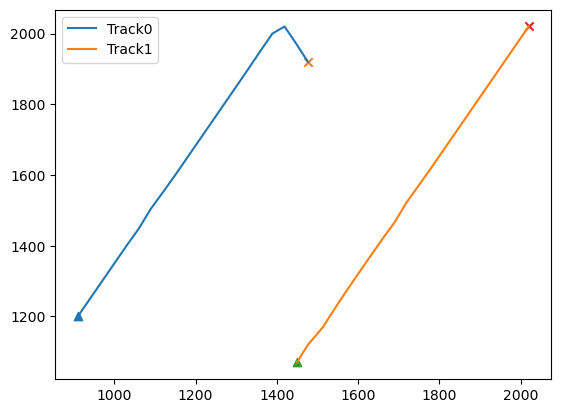

In [10]:
# A simple plot of the track's position can be made using:
for i in dstracks.tracks.values:
    duration_i = dstracks.sel(tracks=i).track_duration.values.item() 
    plt.scatter(dstracks.sel(tracks=i).meanlon.values[0], dstracks.sel(tracks=i).meanlat.values[0], marker='^')  # Start point.
    plt.scatter(dstracks.sel(tracks=i).meanlon.values[duration_i - 1], dstracks.sel(tracks=i).meanlat.values[duration_i - 1], marker='x')  # End point.
    plt.plot(dstracks.sel(tracks=i).meanlon.values, dstracks.sel(tracks=i).meanlat.values, label=f'Track{i}')
    plt.legend()

In [ ]:
### Accessing pixel-level data
# Read in pixel-level data for the specified time period
all_dstracks_pbc = xr.open_mfdataset(
    sorted(pixeldir.glob("**/*.nc")),
    concat_dim="time",
    combine="nested",
    mask_and_scale=False,
)


In [ ]:
### Visualization setup


%%capture
# Set up a figure to use for the animation below.
fig, ax = plt.subplots()
fig.set_size_inches((6, 6))

In [ ]:
# Choose one track.
track =  dstracks.sel(tracks=1).copy()
duration = track.track_duration.values.item()  
track_dates = track.base_time.values[:duration]

In [35]:
# Wrap positions back into domain for plotting if pbc_flag = 1 
# Get domain maximum values 
map_extent = [all_dstracks_pbc['lon'].min().item(), all_dstracks_pbc['lon'].max().item(), 
             all_dstracks_pbc['lat'].min().item(), all_dstracks_pbc['lat'].max().item()]
domain_max_x = map_extent[1] - map_extent[0]
domain_max_y = map_extent[3] - map_extent[2]
# Get adjusted positions
adjusted_lon = track.meanlon.values
adjusted_lat = track.meanlat.values

# Wrap positions back into domain for plotting
wrapped_lon = np.mod(adjusted_lon - map_extent[0], domain_max_x) + map_extent[0]
wrapped_lat = np.mod(adjusted_lat - map_extent[2], domain_max_y) + map_extent[2]

# Identify where wrap-around occurs to split the trajectory
lon_diff = np.abs(np.diff(wrapped_lon))
lat_diff = np.abs(np.diff(wrapped_lat))
wrap_indices = np.where((lon_diff > (domain_max_x / 2)) | (lat_diff > (domain_max_y / 2)))[0] + 1

# Split the trajectory at wrap-around points
split_lon = np.split(wrapped_lon, wrap_indices)
split_lat = np.split(wrapped_lat, wrap_indices)

In [ ]:
# Create an animation of the track, TB and precip. 
cmap = mpl.cm.get_cmap('jet')
# The animation will show the pixel-level data for each time step of the track.

def plot_track_link_pixel(i):
    print(f'{i + 1}/{duration}')
    ax.clear()
    
    date = track_dates[i]
    ax.set_title(date)

    # Get the correct pixel-level dataset frame for the current time of the track.
    dsframe = all_dstracks_pbc.sel(time=date) 
    # Display pixel data.
    ax.contourf(dsframe.lon, dsframe.lat, dsframe.precipitation, levels=[1, 2, 4, 8, 16, 32, 64], colors=[cmap(v) for v in np.linspace(0, 1, 7)])
    ax.contour(dsframe.lon, dsframe.lat, dsframe.tb, levels=[241], colors=['grey'])
    # Here, only the values within the frame with the correct cloudtracknumber 
    ax.contour(dsframe.lon, dsframe.lat, dsframe.cloudtracknumber == track.tracks.values +1, levels=[0.5], colors=['r'])
    # Display track path.
    ax.scatter(wrapped_lon[0], wrapped_lat[0], marker='^', c='g')
    ax.scatter(wrapped_lon[duration - 1], wrapped_lat[duration - 1], marker='x', c='g')
    ax.scatter(wrapped_lon[i], wrapped_lat[i], marker='o', c='g')

    if track.pbc_flag ==1:
        for lon_seg, lat_seg in zip(split_lon, split_lat):
            # Ensure there are at least two points to plot a line
            if len(lon_seg) >= 2:
                ax.plot(lon_seg, lat_seg, 'g-')
            else:
                # For single points, plot as markers
                ax.scatter(lon_seg, lat_seg, 'g-')
    else:
        ax.plot(wrapped_lon.values, wrapped_lat.values, 'g-')
    clear_output(wait=True)
    
anim = matplotlib.animation.FuncAnimation(fig, plot_track_link_pixel, frames=duration, interval=500)
anim